<a href="https://colab.research.google.com/github/castudil/som-lstm/blob/main/MiniSom/MiniSOm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [4]:
#!pip install minisom

  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=aa8dbcc859ad1f9a9645fc7aa9acce7c1210e63a19e9b9ff3d3ec1b7b5fffe45
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built minisom


In [6]:
from minisom import MiniSom    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Iris

In [7]:
#url='data/iris.csv'
url='https://raw.githubusercontent.com/piremonte/datasets/master/iris/Iris.csv'
df = pd.read_csv(url, sep=',', decimal=".")
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [15]:
data = df[df.columns[1:5]] ## remove categories

# data normalization
#data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data 

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [16]:
data = data.values ### transformar a numpy array
data[1:5,] ## mostrar unos pocos

array([[4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [17]:
data.shape[1] # dimensiones

4

In [18]:
# Initialization and training
n_neurons = 10
m_neurons = 10
# initialization and training of 10x10 SOM
som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=2, learning_rate=.5,
              activation_distance='euclidean', neighborhood_function='gaussian', random_seed=11)

som.pca_weights_init(data) ### iniciaclizacion malla usando vectores PCA. fue mejor que inicializar al azar.
som.train(data, 100000, verbose=True)  # random training

som.topographic_error(data)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.20278432118990172


0.04

## Experimento 1

In [19]:
def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.
    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return np.sqrt(np.dot(x, x.T))

In [20]:
def perturbation(instance, num_muta=100, mu=0, sigma=0.1):
    """
    Funcion que perturba una columna de un dataframe, con una cantidad 
    normalmente distribuida con media 0 y desviación típica 0,1 por defecto.

    Parameters
        -----------
    instance : np.array
        instancia que será perturbada
    num_muta : int
        cantidad de perturbaciones a generar
    mu: float
        mean
    sigma: float
        desviación estándar
    """
    df =[] # inicia el array 
    prueba=[]

    cardinality = instance.shape[0] # numero de columnas de la instancia

    for i in range(num_muta):
        stop=True
        while stop:
            # Toma muestras aleatorias de una distribución normal
            noise = pd.Series(np.random.normal(loc=mu, scale=sigma, size=cardinality))
            element = np.array(instance + noise) 
            df.append(element)
            stop = False
            # exist_element =np.array(list(map(lambda x : not np.array_equiv(element, x), df))).all() #np.array([ (element == d).all() for d in df])
    
            # prueba.append(exist_element)
            # if i == 0 or exist_element:
            #     df.append(element)
            #     stop = False
    #print(np.array(prueba).all())
    return np.array(df)

In [22]:
#### asi podemos consultar el vector que representa una instancia
ins = 0
print('Instancia ',ins,': ', data[ins]).

Instancia  0 :  [5.1 3.5 1.4 0.2]


In [24]:
def promedio_error_acumulado_som(instancia, modelo, num_muta=100):  ##TODO: ESCRIBIR ALGORITMO
    # Generación de instancias perturbadas manualmente
    ins_perturbate =perturbation(instancia, num_muta)

    # 2- Se identifica la neurona que representa a la instancia seleccionada 'x'.
    bmu = modelo.quantization(np.array([instancia]))[0]

    # 3- Para cada instancia perturbada, se identifica a la neurona que la representa.
    bmu_mutantes = [modelo.quantization(np.array([ins]))[0] for ins in ins_perturbate]

    #4- Calcula la distancia/error que existe entre la neurona que representa a ´x´ y la neuronas que representa a las mutante.
    distancias = np.array([fast_norm(bmu-bmu_mutante) for bmu_mutante in bmu_mutantes])

    # 5- Calcula el error acumulado
    error_acum = distancias.sum() / len(ins_perturbate)

    return (error_acum, ins_perturbate)

In [25]:
error, ins_perturbate = promedio_error_acumulado_som(data[ins],som, 100)
error

0.10073858793405231

Se puede ver en la malla las neuronas que se activaron con los datos perturbados

In [26]:
som.activation_response(ins_perturbate).T

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5., 20.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 11., 41.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  4., 14.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

#graficar perturbacione en malla SOM
#TODO: crear funcion
# TODO : parametro de la funcion que permita ver instancias del dataset en gris con alpha muy bajo

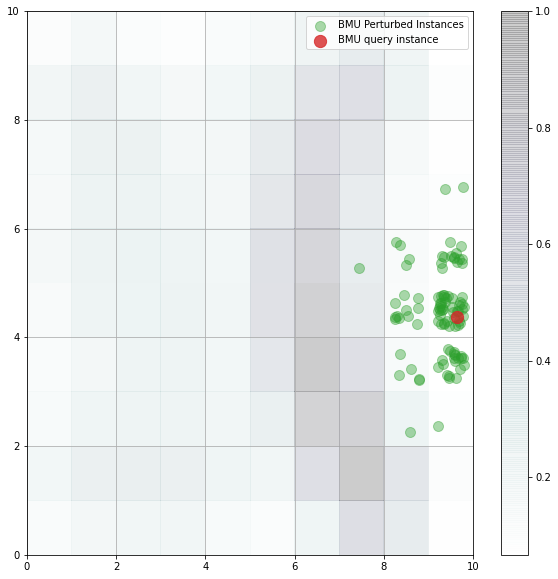

In [34]:
w_x, w_y = zip(*[som.winner(d) for d in ins_perturbate]) ## obtener coordenadas de las perturbaciones
w_x = np.array(w_x) ## vectores de las columnas de todas las neuronas que representan a las perturbaciones.
w_y = np.array(w_y) ## idem para filas en la malla SOM

w_x_ins, w_y_ins = zip(*[som.winner(data[ins])]) ### coordenadas de la BMU
w_x_ins = np.array(w_x_ins)
w_y_ins = np.array(w_y_ins)


plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

colors = ['C3', 'C2']

plt.scatter(w_x+.5+(np.random.rand(ins_perturbate.shape[0])-.5)*.6,
            w_y+.5+(np.random.rand(ins_perturbate.shape[0])-.5)*.6, 
            s=100, c=colors[1], label="BMU Perturbed Instances", alpha=.4) ## rand le da un a especie de Jitter para que no aparezcan en el mimos punto
plt.scatter(w_x_ins+.5+(np.random.rand(1)-.5)*.6,
            w_y_ins+.5+(np.random.rand(1)-.5)*.6, 
            s=150, c=colors[0], label="BMU query instance", alpha=.8) 
plt.legend(loc='upper right')
plt.grid()
#plt.savefig('images/som_seed_pert.png')
plt.show()

## Gráficas

### TODO: crear una funcion

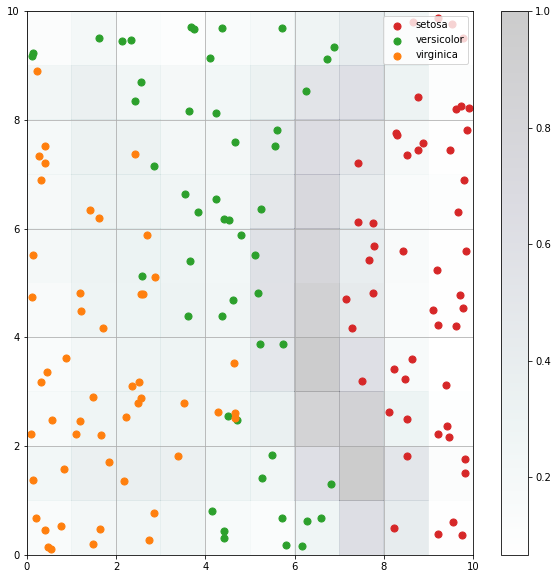

In [ ]:
w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

colors = ['C3', 'C2', "C1"]

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.savefig('images/som_seed.png')
plt.show()

TODO: crear una funcion

Explicar en texto que es lo que hace

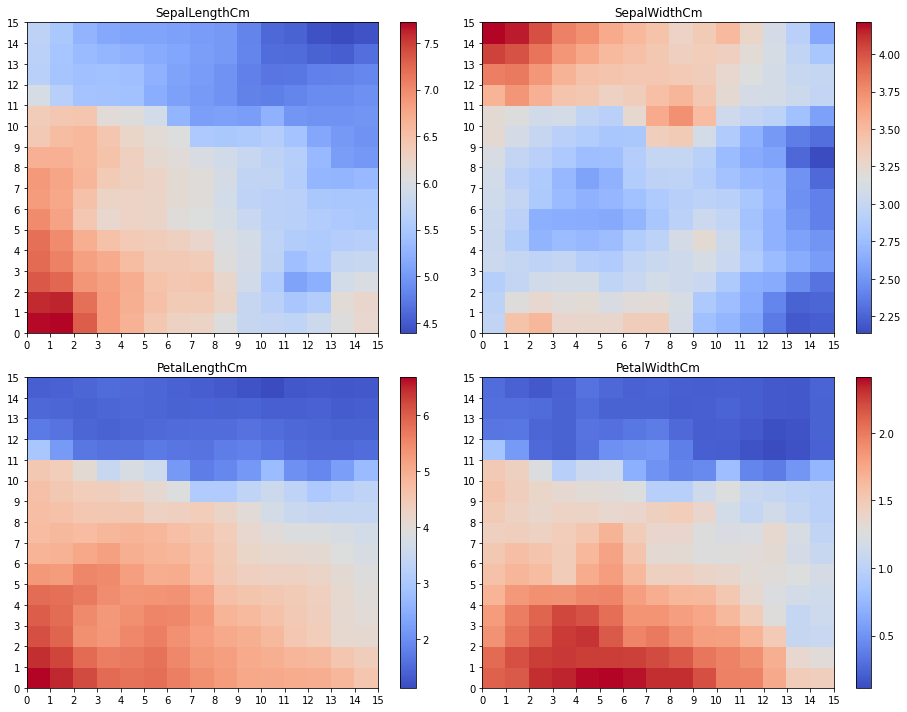

In [ ]:
W = som.get_weights()
plt.figure(figsize=(13, 10))

for i, f in enumerate(df.columns[1:5]):
    plt.subplot(2, 2, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.colorbar()
    plt.xticks(np.arange(n_neurons+1))
    plt.yticks(np.arange(m_neurons+1))
plt.tight_layout()
plt.show()